In [126]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
parent_directory = str(Path().resolve().parent)
parent_directory

import os,sys 
script_path = os.path.abspath("../src")  # Adjust the path
sys.path.append(script_path)
print(parent_directory)

/Users/yiminglin/Documents/Codebase/doc-provenance


In [97]:
import json 
import tiktoken

def read_json(path):
    if not os.path.exists(path):
        print('File not found!', path)
        return None
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def count_tokens(text, model="gpt-4o-mini"):
    encoder = tiktoken.encoding_for_model(model)  # Get the tokenizer for the specific model
    tokens = encoder.encode(text)  # Encode text into tokens
    return len(tokens)

def write_json_to_file(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

In [153]:
def get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset):
    objects = read_json(data_path)
    results = {}
    strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
    i = 0
    num_case = 500
    for o in objects:
        i += 1
        if dataset == 'hotpotQA':
            title = o['document_name']
        else:
            title = o['id']
        result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + strategy + '.json'
        if not os.path.exists(result_path):
            # if i < num_case:
            #     print('path not exist:', result_path)
            continue
        result = read_json(result_path)
        if 'tokens' not in result:
            # if i < num_case:
            #     print('result not exist:', result_path)
            continue
        r = {}
        #print(i, strategy)
        r['document_size'] = result['document_size']
        r['provenance_size'] = result['provenance_size']
        r['time'] = result['time']
        r['tokens'] = result['tokens']
        results[i] = r

    return results        

def get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset): 

    size_ratios = {}
    large_case_ids = {}
    medium_case_ids = {}
    provenance_size_dict = {}
    size_ratio_dict = {}
    time_dict = {}
    cost_dict = {}
    document_size_dict = {}

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            # if minimal_provenance_strategy != 'null':
            #     continue
            print(strategy)
            results = get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset)
            #print(len(results))
            avg_provenance_size = 0
            avg_size_ratio = 0
            avg_time = 0
            avg_in_tokens = 0
            avg_out_tokens = 0
            avg_document_size = 0

            size_ratio_list = []
            large_case_id = []
            medium_case_id = []
            for rid, result in results.items():
                size_ratio = result['provenance_size']/result['document_size']
                provenance_size = result['provenance_size']
                time = result['time']
                in_tokens = result['tokens'][0]
                out_tokens = result['tokens'][1] 
                document_size = result['document_size']

                avg_provenance_size += provenance_size
                avg_size_ratio += size_ratio
                avg_time += time 
                avg_in_tokens += in_tokens
                avg_out_tokens += out_tokens
                avg_document_size += document_size

                if size_ratio > 0.9:
                    large_case_id.append(rid)
                    #print('large size ratio:', rid)
                elif size_ratio < 0.9 and size_ratio > 0.3:
                    medium_case_id.append(rid)

                size_ratio_list.append(size_ratio)

            avg_provenance_size /= len(results)
            avg_size_ratio /= len(results)
            avg_time /= len(results)
            avg_in_tokens /= len(results)
            avg_out_tokens /= len(results)
            avg_document_size /= len(results)
            print('provenance_size, size_ratio:', avg_provenance_size, avg_size_ratio)
            print('time:', avg_time)
            print('tokens:', avg_in_tokens, avg_out_tokens)
            print('')
            size_ratios[strategy] = size_ratio_list
            large_case_ids[strategy] = large_case_id
            medium_case_ids[strategy] = medium_case_id

            provenance_size_dict[strategy] = avg_provenance_size
            size_ratio_dict[strategy] = avg_size_ratio
            time_dict[strategy] = avg_time
            cost_dict[strategy] = avg_in_tokens + avg_out_tokens
            document_size_dict[strategy] = avg_document_size

    return size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict

def plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios):
    # Prepare your strategies
    plots = []
    titles = []

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            # if minimal_provenance_strategy != 'null':
            #     continue
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            print(strategy)
            a = size_ratios[strategy]
            plots.append(a)
            titles.append(strategy)

    # Set up subplots
    n = len(plots)
    cols = 3  # adjust columns as needed
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (a, title) in enumerate(zip(plots, titles)):
        counts, bins, _ = axes[i].hist(a, bins='auto', edgecolor='black')
        total = counts.sum()
        percentages = (counts / total) * 100

        # Clear and re-plot using percentages
        axes[i].cla()
        axes[i].bar(bins[:-1], percentages, width=np.diff(bins), align='edge', edgecolor='black')
        axes[i].set_title(f'{title}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency (Percentage)')
        axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict):
        format_dict = lambda d: {k: f"{v:.2f}" for k, v in d.items()}

        form_provenance_size_dict = format_dict(provenance_size_dict)
        form_size_ratio_dict = format_dict(size_ratio_dict)
        form_time_dict = format_dict(time_dict)
        form_cost_dict = format_dict(cost_dict)

        df = pd.DataFrame({'Provenance Size (Tokens)': form_provenance_size_dict, 'Provenance Size Ratio': form_size_ratio_dict, 'Latency': form_time_dict, 'Used Tokens': form_cost_dict})
        # Plot the table with larger size
        fig, ax = plt.subplots(figsize=(8, len(df)*0.6 + 1))  # Adjust height based on number of rows
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(cellText=df.values,
                        rowLabels=df.index,
                        colLabels=df.columns,
                        cellLoc='center',
                        loc='center')

        # Increase font size
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)  # scale width, height

        try:
            table.auto_set_column_width(col=list(range(len(df.columns) + 1)))  # +1 for row labels
        except AttributeError:
            print("auto_set_column_width not available — upgrade matplotlib to >=3.4 for best effect.")


        plt.show()

In [ ]:
#nl_dev  

dataset = 'nl_dev'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/natural-questions_nq-dev-full.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/nl_dev/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)


                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 1256.9683544303798 0.16382934813659375
time: 3.141283622270898
tokens: 4361.2468354430375 33.572784810126585

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 313.0308641975309 0.060872858887061995
time: 20.427735792266
tokens: 42591.70987654321 361.0246913580247

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 302.67088607594934 0.061294509890726934
time: 27.119064398204223
tokens: 68474.37025316455 476.9145569620253

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1970.0372881355931 0.23223341065795186
time: 4.187940395484536
tokens: 8291.908474576272 41.13898305084746

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 495.38255033557044 0.0800333688647945
time: 39.58847775155266
tokens: 243097.74832214764 743.6476510067114

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 345.1637630662021

8230.142274959866


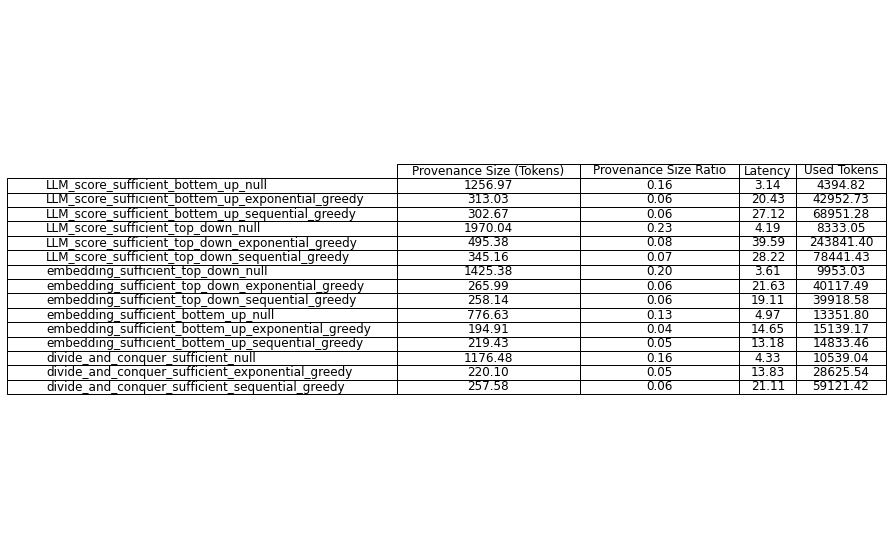

In [155]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

In [90]:
def get_diff(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    common = set1 & set2
    return sorted(list((set1 | set2) - common))

result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/nl_dev/results/'

old_large_id_path = result_folder_path + 'large_cases.json' 
new_large_id_path = result_folder_path + 'new_large_cases.json'
old_medium_id_path = result_folder_path + 'medium_cases.json'
new_medium_id_path = result_folder_path + 'new_medium_cases.json'

old_lage_ids = read_json(old_large_id_path)
new_large_ids = read_json(new_large_id_path)
old_medium_ids = read_json(old_medium_id_path)
new_medium_ids = read_json(new_medium_id_path)

diff_ids = {}
for strategy, old_large_id in old_lage_ids.items():
    new_large_id = new_large_ids[strategy]
    large_diff = get_diff(old_large_id, new_large_id)
    print(strategy)
    # print(old_large_id)
    # print(new_large_id)
    # print(large_diff)
    old_medium_id = old_medium_ids[strategy]
    new_medium_id = new_medium_ids[strategy]
    medium_diff = get_diff(old_medium_id, new_medium_id)
    ids = sorted(set(large_diff + medium_diff)) 
    diff_ids[strategy] = ids
    # print(old_medium_id)
    # print(new_medium_id)
    # print(medium_diff)
write_json_to_file(result_folder_path + 'diff_ids.json', diff_ids)


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


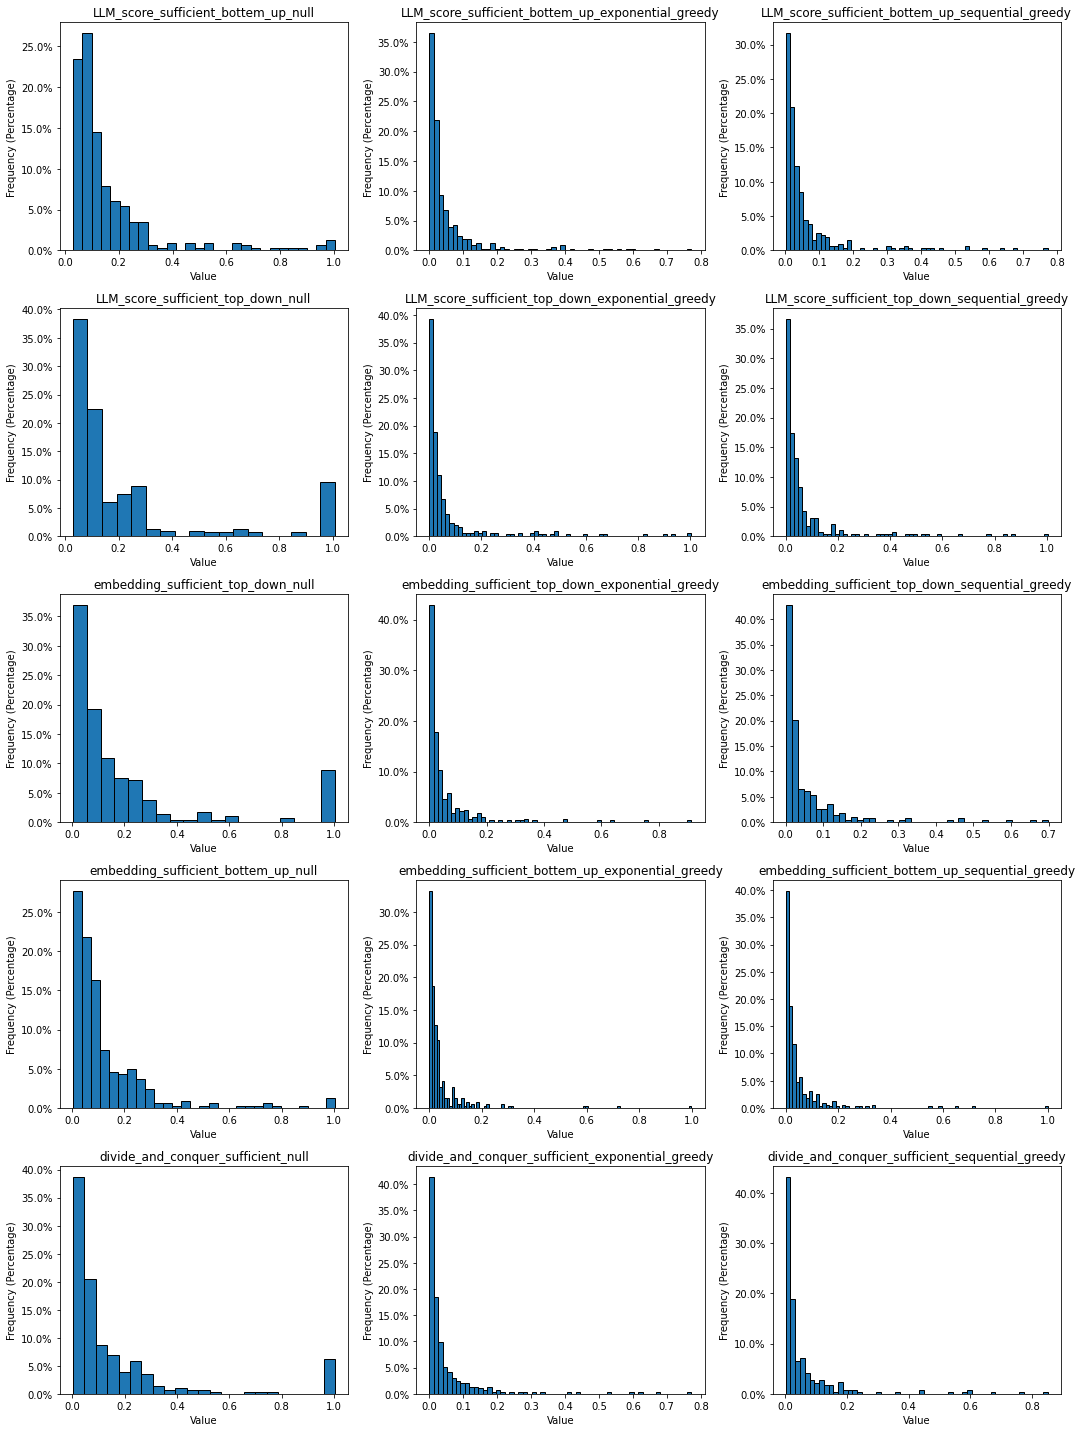

In [ ]:

plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)



In [156]:
#paper 

dataset = 'paper'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/qasper_sample_papers.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/paper/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 660.1671087533157 0.12882001342525418
time: 3.2499394853171997
tokens: 2293.46949602122 26.084880636604776

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 200.06410256410257 0.04255850139339208
time: 23.116661277795448
tokens: 27533.528205128205 467.84871794871793

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 178.43846153846152 0.038720385831867626
time: 20.532000908484825
tokens: 19754.34358974359 360.35128205128206

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1028.1349693251534 0.19210769203485445
time: 4.016267977609225
tokens: 4450.199386503067 40.88650306748466

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 189.5579268292683 0.04416277960627704
time: 21.45502406213342
tokens: 21201.01219512195 376.9908536585366

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 173.6153846153

5155.40598174443


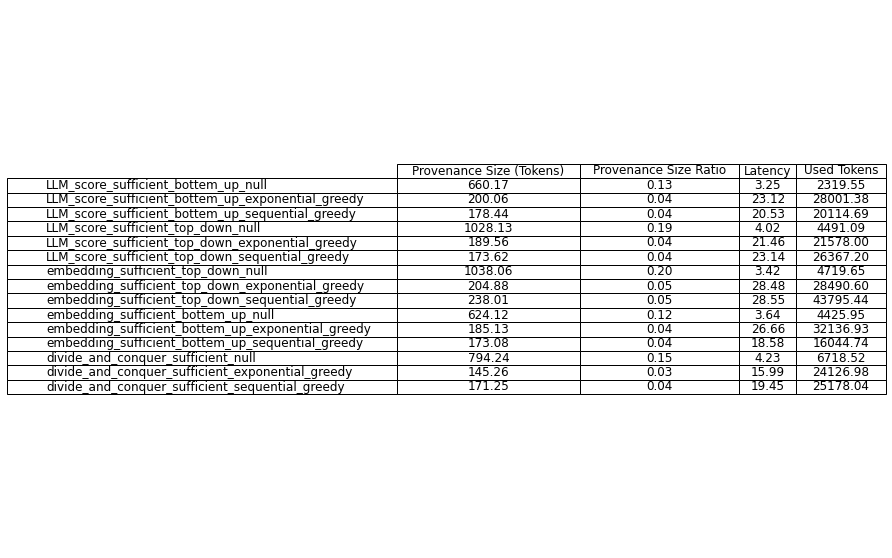

In [157]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

In [92]:
def get_diff(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    common = set1 & set2
    return sorted(list((set1 | set2) - common))

result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/paper/results/'

old_large_id_path = result_folder_path + 'large_cases.json' 
new_large_id_path = result_folder_path + 'new_large_cases.json'
old_medium_id_path = result_folder_path + 'medium_cases.json'
new_medium_id_path = result_folder_path + 'new_medium_cases.json'

old_lage_ids = read_json(old_large_id_path)
new_large_ids = read_json(new_large_id_path)
old_medium_ids = read_json(old_medium_id_path)
new_medium_ids = read_json(new_medium_id_path)

diff_ids = {}
for strategy, old_large_id in old_lage_ids.items():
    new_large_id = new_large_ids[strategy]
    large_diff = get_diff(old_large_id, new_large_id)
    print(strategy)
    # print(old_large_id)
    # print(new_large_id)
    # print(large_diff)
    old_medium_id = old_medium_ids[strategy]
    new_medium_id = new_medium_ids[strategy]
    medium_diff = get_diff(old_medium_id, new_medium_id)
    ids = sorted(set(large_diff + medium_diff)) 
    diff_ids[strategy] = ids
    # print(old_medium_id)
    # print(new_medium_id)
    # print(medium_diff)
write_json_to_file(result_folder_path + 'diff_ids.json', diff_ids)


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


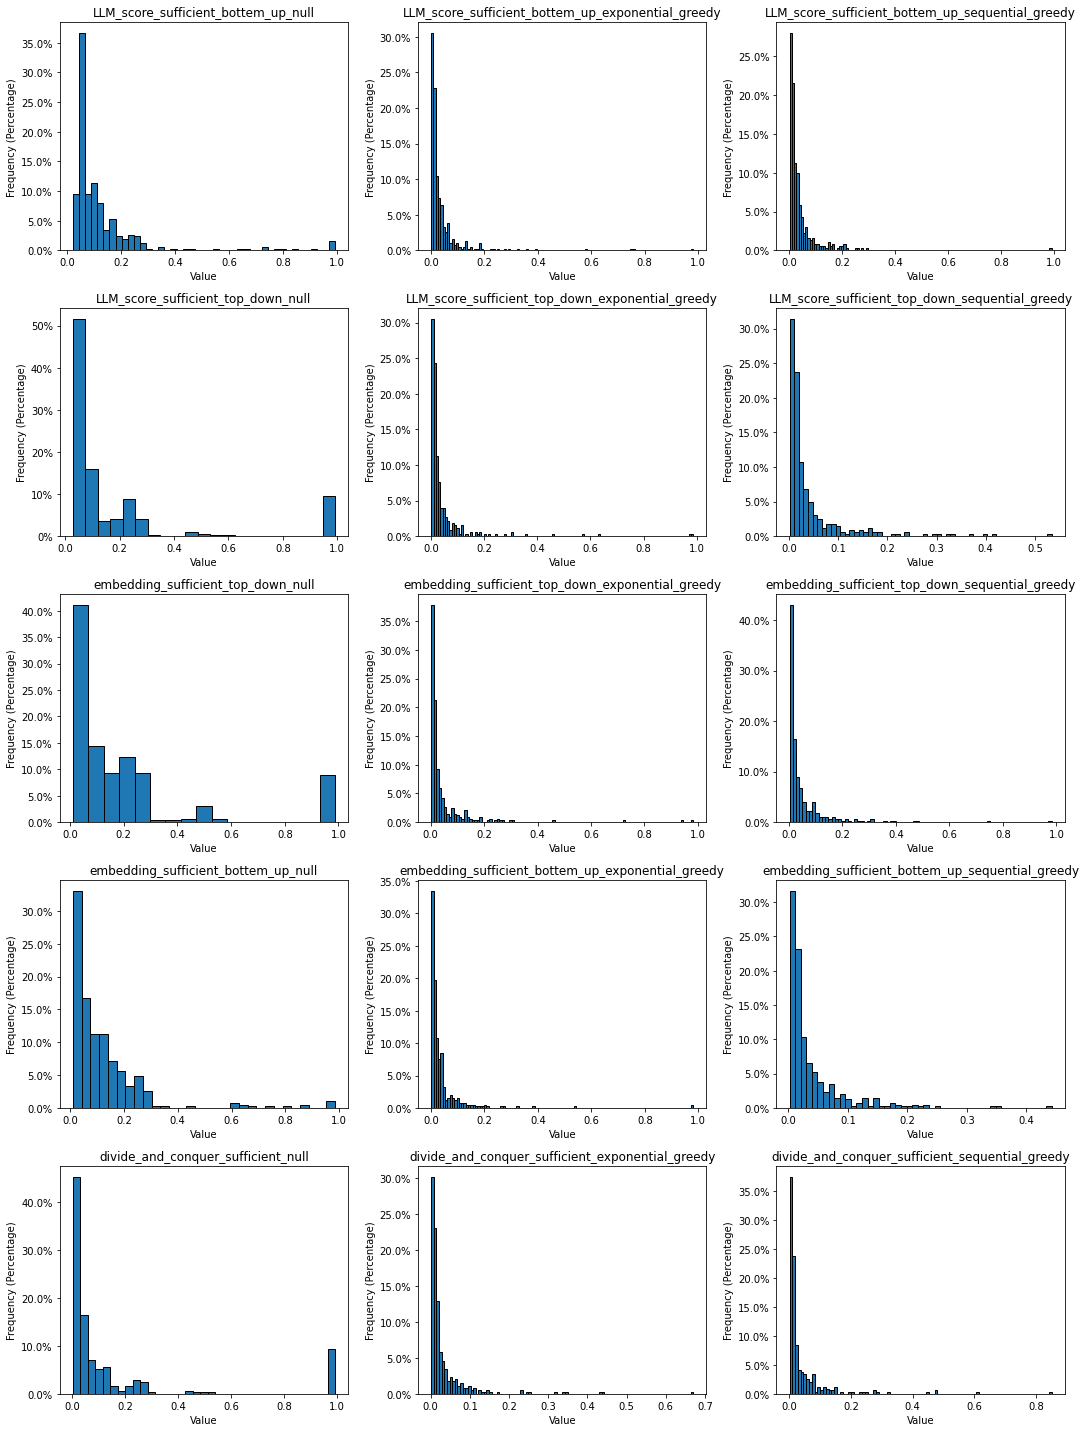

In [118]:
plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios_paper)



In [158]:
#hotpot 

dataset = 'hotpotQA'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/hotpotQA_fullwiki.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/hotpotQA/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 287.3775510204082 0.24822992006813688
time: 1.785233084847327
tokens: 444.6020408163265 5.098639455782313

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 93.39525691699605 0.07990010310709393
time: 5.731954259834742
tokens: 3045.3715415019765 34.03557312252964

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 98.29527559055119 0.08471291700840855
time: 6.254156037578433
tokens: 3249.0787401574803 38.181102362204726

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 353.1587837837838 0.29371695340139903
time: 1.8538886832224357
tokens: 970.7162162162163 8.516891891891891

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 111.55212355212355 0.09298772032612662
time: 6.824419411913309
tokens: 4734.791505791506 51.01930501930502

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 127.23371647509579 

1251.8871705486758


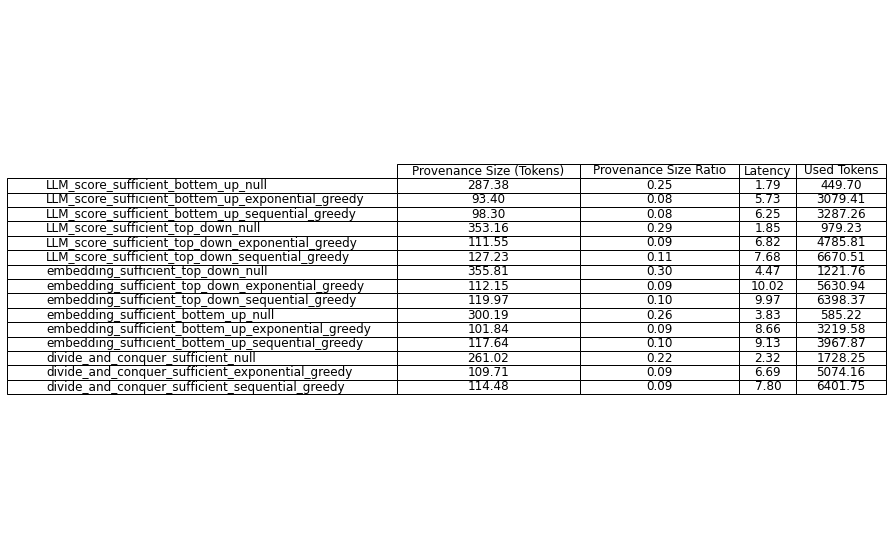

In [159]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

In [95]:
def get_diff(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    common = set1 & set2
    return sorted(list((set1 | set2) - common))

result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/hotpotQA/results/'

old_large_id_path = result_folder_path + 'large_cases.json' 
new_large_id_path = result_folder_path + 'new_large_cases.json'
old_medium_id_path = result_folder_path + 'medium_cases.json'
new_medium_id_path = result_folder_path + 'new_medium_cases.json'

old_lage_ids = read_json(old_large_id_path)
new_large_ids = read_json(new_large_id_path)
old_medium_ids = read_json(old_medium_id_path)
new_medium_ids = read_json(new_medium_id_path)

diff_ids = {}
for strategy, old_large_id in old_lage_ids.items():
    new_large_id = new_large_ids[strategy]
    large_diff = get_diff(old_large_id, new_large_id)
    print(strategy)
    # print(old_large_id)
    # print(new_large_id)
    # print(large_diff)
    old_medium_id = old_medium_ids[strategy]
    new_medium_id = new_medium_ids[strategy]
    medium_diff = get_diff(old_medium_id, new_medium_id)
    ids = sorted(set(large_diff + medium_diff)) 
    diff_ids[strategy] = ids
    # print(old_medium_id)
    # print(new_medium_id)
    # print(medium_diff)
write_json_to_file(result_folder_path + 'diff_ids.json', diff_ids)


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_top_down_null
embedding_sufficient_top_down_null
embedding_sufficient_bottem_up_null
divide_and_conquer_sufficient_null


LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


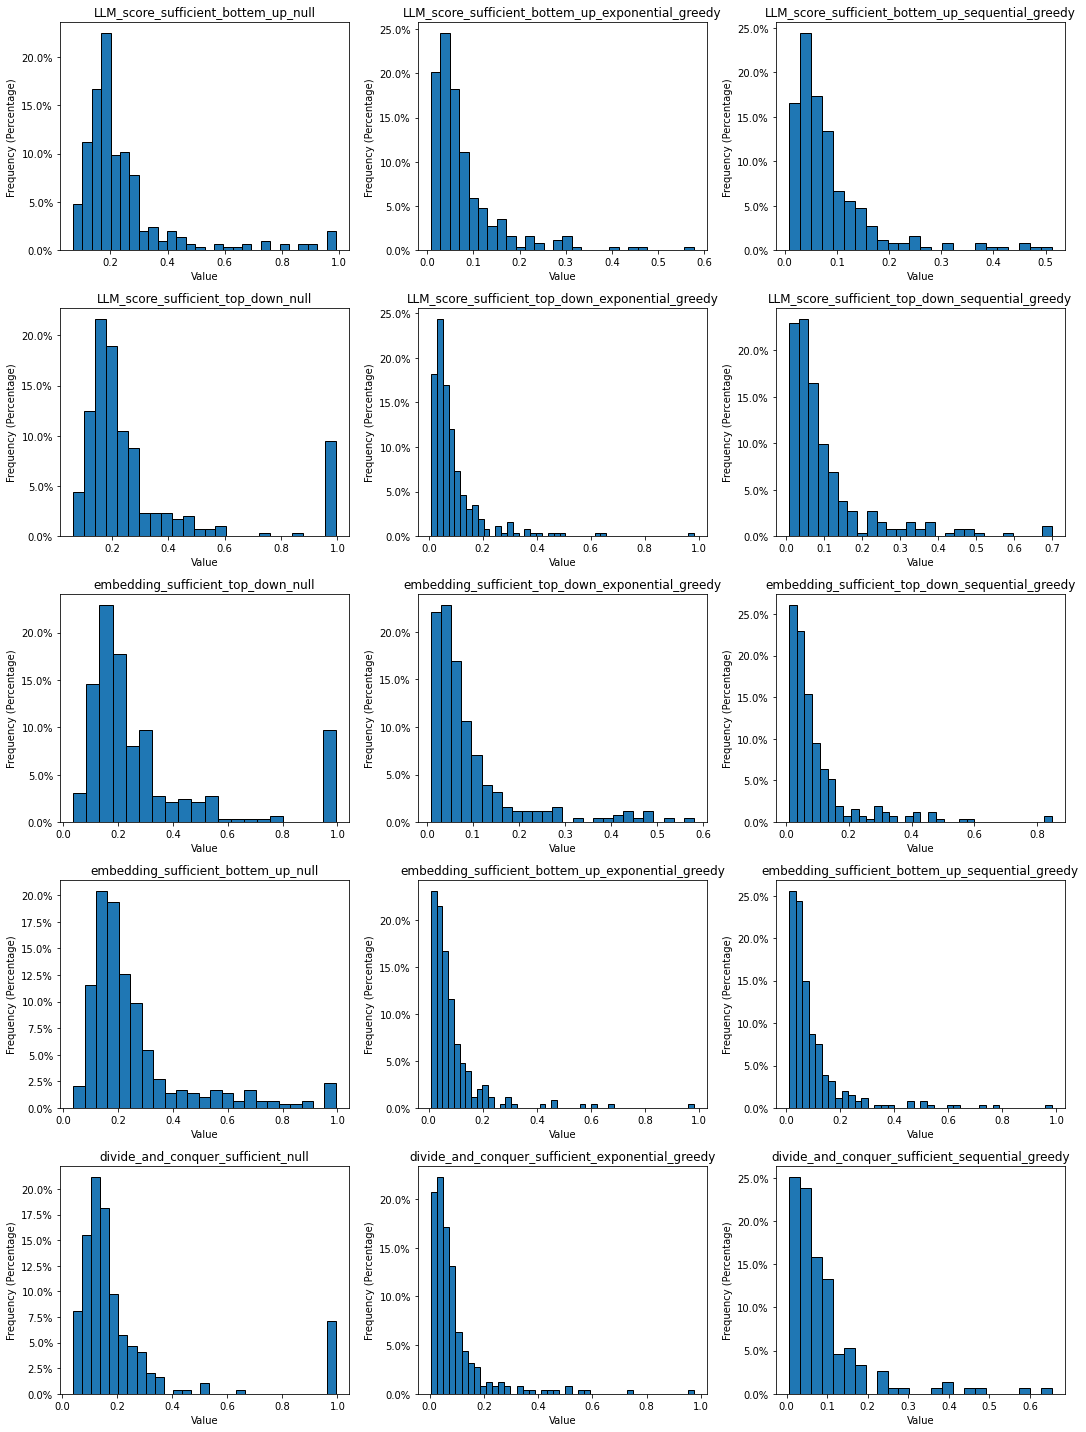

In [ ]:
plot_size_ratio_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)

